In [48]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [49]:
def mandelbrot_iteration_cplx(cx,cy,nitrmax):
    c = complex(cx, cy)
    z = complex(0, 0)
    for i in range(nitrmax):
        z = z ** 2 + c
        if abs(z) > 4 :
            return i
    return nitrmax - 1

In [50]:
def mandelbrot_iteration_arith(cx, cy, nitermax):
    x = 0
    y = 0
    for n in range(nitermax):
        x2 = x*x
        y2 = y*y
        if x2+y2 > 4:
            return n
        x, y = x2-y2+cx, 2*x*y+cy
    return nitermax

In [51]:
def mandelbrot(xmin,xmax,ymin,ymax,npts,nitrmax,mandelbrot_f):
    data = np.empty(shape=(npts, npts), dtype=np.int)
    dx = (xmax-xmin)/(npts-1)
    dy = (ymax-ymin)/(npts-1)
    
    for nx in range(npts):
        x = xmin+nx*dx
        for ny in range(npts):
            y = ymin+ny*dy
            data[ny, nx] = mandelbrot_f(x, y, nitermax)
    return data

In [52]:
def plot(data):
    plt.imshow(data, extent=(xmin, xmax, ymin, ymax),
               cmap='magma', origin='bottom', interpolation='bicubic')
    plt.show()

In [53]:
nitermax = 2000
npts = 1024
xmin = -2
xmax = 1
ymin = -1.5
ymax = 1.5

/home/lina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


arithmetique op / execution time : 92.54246282577515


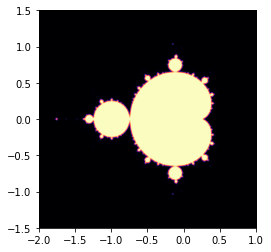

complexe / execution time : 95.59104776382446


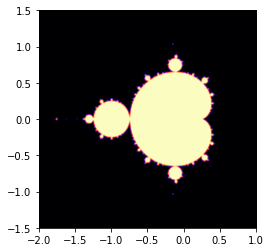

In [54]:
start = time.time()
data = mandelbrot(xmin, xmax, ymin, ymax, npts, nitermax,mandelbrot_iteration_arith)
ende = time.time()
print(f"arithmetique op / execution time : {ende- start}")
plot(data)

start = time.time()
data = mandelbrot(xmin, xmax, ymin, ymax, npts, nitermax,mandelbrot_iteration_cplx)
ende = time.time()
print(f"complexe / execution time : {ende- start}")
plot(data)

In [57]:
def mandelbrot(xmin, xmax, ymin, ymax, npts, nitermax):
    cy, cx = np.mgrid[ymin:ymax:npts*1j, xmin:xmax:npts*1j]
    x = np.zeros_like(cx)
    y = np.zeros_like(cx)
    data = np.zeros(cx.shape, dtype=np.int)
    for n in range(nitermax):
        x2 = x*x
        y2 = y*y
        notdone = x2+y2 < 4
        data[notdone] = n
        x[notdone], y[notdone] = (x2[notdone]-y2[notdone]+cx[notdone],2*x[notdone]*y[notdone]+cy[notdone])
    return data

/home/lina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


using numpy / execution time : 31.990052461624146


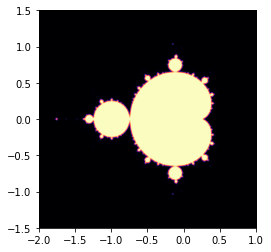

In [58]:
nitermax = 2000
npts = 1024
xmin = -2
xmax = 1
ymin = -1.5
ymax = 1.5
start = time.time()
data = mandelbrot(xmin, xmax, ymin, ymax, npts, nitermax)
ende = time.time()
print(f"using numpy / execution time : {ende- start}")
plot(data)

#  NumPy based version can be adapted to a parallel treatment.

In [117]:
from concurrent import futures
from itertools import product
from functools import partial
import time
import numpy as np
import matplotlib.pyplot as plt

In [122]:
def mandelbrot_tile(nitermax, nx, ny, cx, cy):
    x = np.zeros_like(cx)
    y = np.zeros_like(cx)
    data = np.zeros(cx.shape, dtype=np.int)
    for n in range(nitermax):
        x2 = x*x
        y2 = y*y
        notdone = x2+y2 < 4
        data[notdone] = n
        x[notdone], y[notdone] = (x2[notdone]-y2[notdone]+cx[notdone],2*x[notdone]*y[notdone]+cy[notdone])
    return (nx, ny, data)

In [123]:
def mandelbrot(xmin, xmax, ymin, ymax, npts, nitermax, ndiv, max_workers=4):
    cy, cx = np.mgrid[ymin:ymax:npts*1j, xmin:xmax:npts*1j]
    nlen = npts//ndiv
    paramlist = [
        (nx,
         ny,
         cx[nx*nlen:(nx+1)*nlen,ny*nlen:(ny+1)*nlen],
         cy[nx*nlen:(nx+1)*nlen, ny*nlen:(ny+1)*nlen])
    for nx, ny in product(range(ndiv), repeat=2)]
    with futures.ProcessPoolExecutor(max_workers=max_workers) as executors:
        wait_for = [executors.submit(partial(mandelbrot_tile, nitermax),nx, ny, cx, cy) for (nx, ny, cx, cy) in paramlist]

    results = [f.result() for f in futures.as_completed(wait_for)]
    data = np.zeros(cx.shape, dtype=np.int)
    for nx, ny, result in results:
        data[nx*nlen:(nx+1)*nlen, ny*nlen:(ny+1)*nlen] = result
    return data

/home/lina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


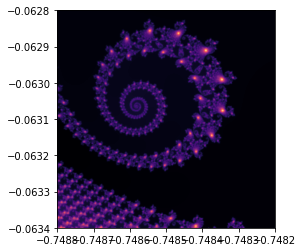

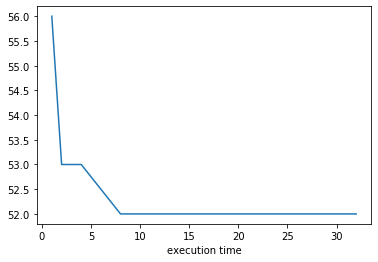

In [124]:
nitermax = 2000
npts = 1024
xmin = -0.7488
xmax = -0.7482
ymin = -0.0634
ymax = -0.0628
ndiv = 8

nndiv = np.zeros(32)
timee = np.zeros(32)

for idiv in range(32):
    start = time.time()
    data = mandelbrot(xmin, xmax, ymin, ymax, npts, nitermax, idiv + 1)
    ende = time.time()
    nndiv[idiv]=idiv
    timee[idiv]=ende - start
#print(f"using adapted parallel numpy / execution time : {ende- start}")
plot(data)

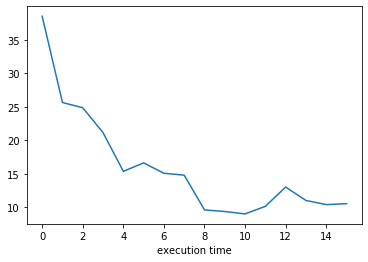

In [125]:
# 
plt.xlabel("divisions")
plt.xlabel("execution time")
plt.plot(nndiv,timee)

# implementation using Numba

In [81]:
def zeta(x, nmax):
    zetasum = 0
    for n in range(1, nmax+1):
        zetasum = zetasum+1/(n**x)
    return zetasum

In [83]:
start = time.time()
z = zeta(2,100000000)
ende = time.time()
print(f"z = {z} and the execution time is : {ende- start}")

z = 1.644934057834575 and the execution time is : 32.92394542694092


In [84]:
import numba

In [88]:
nmax = 100000000

@numba.jit
def zeta(x, nmax):
    zetasum = 0
    for n in range(1, nmax+1):
        zetasum = zetasum+1/(n**x)
    return zetasum

In [90]:
start = time.time()
z = zeta(2,100000000)
print(f"z = {z}\nexecution time is : {time.time()- start}")
print(zeta.signatures)

z = 1.644934057834575
execution time is : 0.4070560932159424
[(int64, int64)]


In [92]:
for x in (2, 2.5, 2+1j):
    start = time.time()
    print(f"zeta({x}) = {zeta(x, nmax)}")
    print('execution time: {:5.2f}s\n'.format(time.time()-start))
print(zeta.signatures)

zeta(2) = 1.644934057834575
execution time:  0.39s

zeta(2.5) = 1.341487257103954
execution time:  7.61s

zeta((2+1j)) = (1.1503556987382961-0.43753086346605924j)
execution time: 15.69s

[(int64, int64), (float64, int64), (complex128, int64)]


In [93]:
import numpy as np
from numba import vectorize, float64, int64

In [94]:
@vectorize([float64(float64, int64)], target='parallel')
def zeta(x, nmax):
    zetasum = 0.
    for n in range(nmax):
        zetasum = zetasum+1./((n+1)**x)
    return zetasum

1 threads : execution time: 56.34s

2 threads : execution time: 53.52s

4 threads : execution time: 53.33s

8 threads : execution time: 52.46s

16 threads : execution time: 52.14s

32 threads : execution time: 52.15s



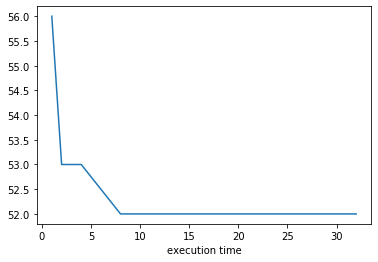

In [112]:
th = np.array([1,2,4,8,16,32])
res= np.array([0,0,0,0,0,0])
x = np.linspace(2,50,20,dtype=np.float64)
!export NUMBA_NUM_THREADS=1
start = time.time()
y = zeta(x,nmax)
ende=time.time()
print('1 threads : execution time: {:5.2f}s\n'.format(ende-start))
res[0] = ende-start

!export NUMBA_NUM_THREADS=2
start = time.time()
y = zeta(x,nmax)
ende=time.time()
print('2 threads : execution time: {:5.2f}s\n'.format(ende-start))
res[1] = ende-start

!export NUMBA_NUM_THREADS=4
start = time.time()
y = zeta(x,nmax)
ende=time.time()
print('4 threads : execution time: {:5.2f}s\n'.format(ende-start))
res[2] = ende-start


!export NUMBA_NUM_THREADS=8
start = time.time()
y = zeta(x,nmax)
ende=time.time()
print('8 threads : execution time: {:5.2f}s\n'.format(ende-start))
res[3] = ende-start


!export NUMBA_NUM_THREADS=16
start = time.time()
y = zeta(x,nmax)
ende=time.time()
print('16 threads : execution time: {:5.2f}s\n'.format(ende-start))
res[4] = ende-start

!export NUMBA_NUM_THREADS=32
start = time.time()
y = zeta(x,nmax)
ende=time.time()
print('32 threads : execution time: {:5.2f}s\n'.format(ende-start))
res[5] = ende-start

plt.xlabel("threads")
plt.xlabel("execution time")
plt.plot(th,res)

In [113]:
!export NUMBA_NUM_THREADS=4

## applying Numba to our Mandelbrot example

In [114]:
from numba import jit, guvectorize, complex128, int64
import matplotlib.pyplot as plt
import numpy as np

In [115]:
def mandelbrot_iter(c, maxiter):
    z = 0
    for n in range(maxiter):
        z = z**2+c
        if z.real*z.real+z.imag*z.imag > 4:
            return n
    return maxiter

In [116]:
@guvectorize([(complex128[:], int64[:], int64[:])], '(n), () -> (n)',target='parallel')
def mandelbrot(c, itermax, output):
    nitermax = itermax[0]
    for i in range(c.shape[0]):
        output[i] = mandelbrot_iter(c[i], nitermax)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'mandelbrot_iter':[0m [1m[1mcannot determine Numba type of <class 'function'>[0m
[1m
File "<ipython-input-116-721d7318cdb9>", line 5:[0m
[1mdef mandelbrot(c, itermax, output):
    <source elided>
    for i in range(c.shape[0]):
[1m        output[i] = mandelbrot_iter(c[i], nitermax)
[0m        [1m^[0m[0m
[0m

In [ ]:
def mandelbrot_set(xmin, xmax, ymin, ymax, npts, nitermax):
    cy, cx = np.ogrid[ymin:ymax:npts*1j, xmin:xmax:npts*1j]
    c = cx+cy*1j
    return mandelbrot(c, nitermax)

In [ ]:
def plot(data):
    plt.imshow(data, extent=(xmin, xmax, ymin, ymax),
               cmap='magma', origin='bottom', interpolation='bicubic')
    plt.show()

In [107]:
nitermax = 2000
npts = 1024
xmin = -2
xmax = 1
ymin = -1.5
ymax = 1.5

start = time.time()
data = mandelbrot_set(xmin, xmax, ymin, ymax, npts, nitermax)
ende = time.time()
print(f"using adapted parallel numpy / execution time : {ende- start}")
plot(data)


NameError: name 'mandelbrot_set' is not defined